In [5]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../PyTorch-Image-Dehazing")
from net import dehaze_net
import torch


# --- 路径 ---
MY_HAZE_DIR = Path("../data/MYHAZE")
RESULT_DCP_MY = Path("../results/dcp/myhaze")
RESULT_AOD_MY = Path("../results/aod/myhaze")

RESULT_DCP_MY.mkdir(parents=True, exist_ok=True)
RESULT_AOD_MY.mkdir(parents=True, exist_ok=True)

haze_files = sorted([f for f in MY_HAZE_DIR.iterdir() if f.suffix.lower() in [".jpg", ".png", ".jpeg"]])


In [6]:
def dehaze_dcp(img_path, size=31, omega=0.88, t0=0.1):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    dark = np.min(img, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark_channel = cv2.erode(dark, kernel)

    # 大气光
    A = np.max(img.reshape(-1, 3), axis=0)

    transmission = 1 - omega * dark_channel
    transmission = np.clip(transmission, t0, 1)

    J = (img - A) / transmission[..., None] + A
    J = np.clip(J, 0, 1)

    return (J * 255).astype(np.uint8)

# --- 运行 DCP ---
for f in haze_files:
    out = dehaze_dcp(f)
    cv2.imwrite(
        str(RESULT_DCP_MY / f.name),
        cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    )


In [8]:
# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = dehaze_net().to(device)
net.load_state_dict(torch.load("../PyTorch-Image-Dehazing/snapshots/dehazer.pth", map_location=device))
net.eval()

def aod_dehaze(img_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    h, w, _ = img.shape

    tens = torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0).float().to(device)
    with torch.no_grad():
        out = net(tens).cpu().numpy()[0].transpose(1,2,0)

    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8)

# --- 运行 AOD ---
for f in haze_files:
    out = aod_dehaze(f)
    cv2.imwrite(
        str(RESULT_AOD_MY / f.name),
        cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    )


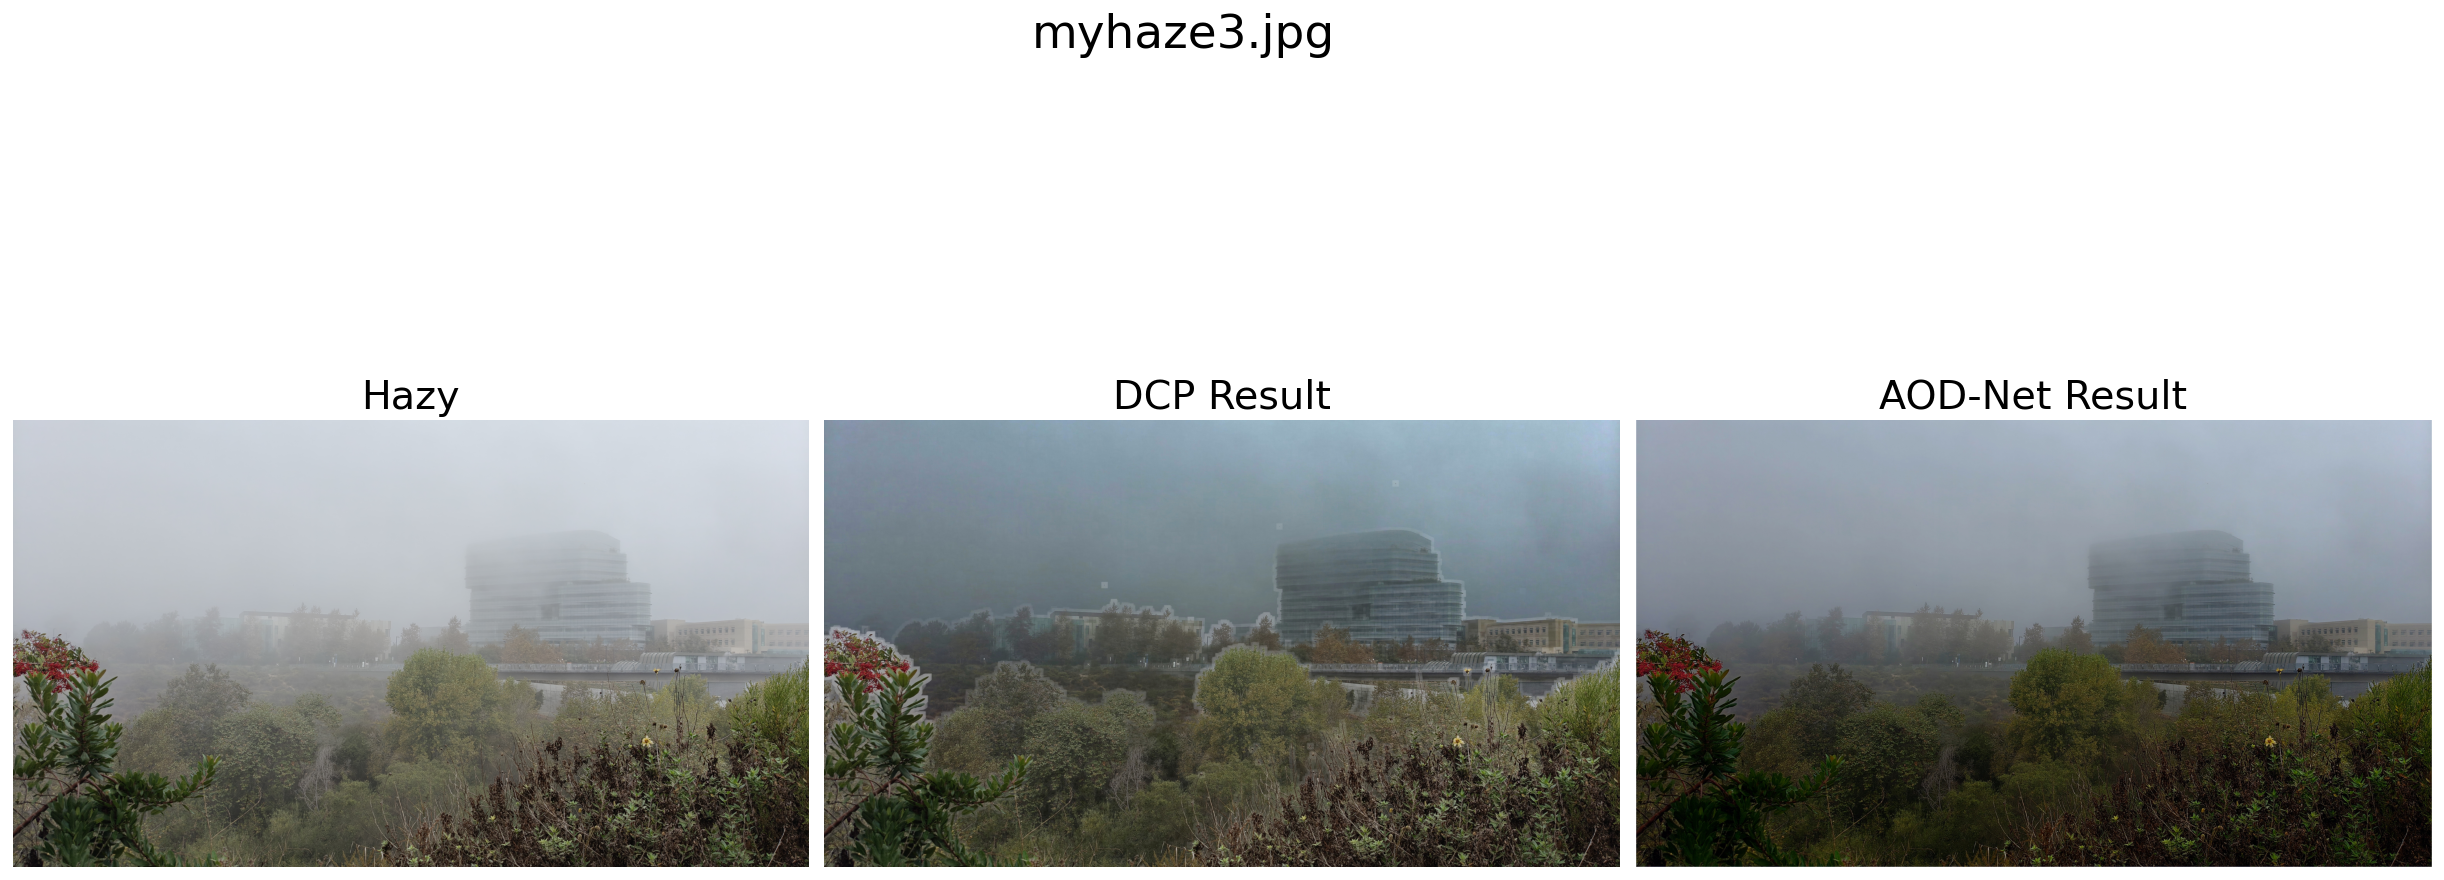

In [18]:
def visualize_myhaze(filename):
    hazy_path = MY_HAZE_DIR / filename
    dcp_path  = RESULT_DCP_MY / filename
    aod_path  = RESULT_AOD_MY / filename

    hazy = cv2.cvtColor(cv2.imread(str(hazy_path)), cv2.COLOR_BGR2RGB)
    dcp  = cv2.cvtColor(cv2.imread(str(dcp_path)),  cv2.COLOR_BGR2RGB)
    aod  = cv2.cvtColor(cv2.imread(str(aod_path)),  cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(24, 10), dpi=130)
    plt.subplots_adjust(wspace=0.02)

    plt.subplot(1,3,1)
    plt.title("Hazy", fontsize=22)
    plt.imshow(hazy)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("DCP Result", fontsize=22)
    plt.imshow(dcp)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("AOD-Net Result", fontsize=22)
    plt.imshow(aod)
    plt.axis("off")

    plt.suptitle(filename, fontsize=26)
    plt.show()


visualize_myhaze("myhaze3.jpg")
